# All vs All

In [1]:
import pickle

import numpy as np

import pandas as pd

% matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set()

import joblib

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler

from libs.container import Container
from libs.display import d
from libs.nearest import nearest
from libs.experiment import KFoldExperiment, WithAnotherExperiment, roc, metrics
from libs.precstar import  prec_star

In [2]:
sample = pd.read_pickle("data/o3o4vZ/scaled/s2_5k.pkl.bz2")
sample["tile"] = sample["id"].apply(lambda i: "b" + str(i)[1:4])
sample["cls"] = sample.vs_type.apply(lambda x: 0 if x == "" else 1)

no_features = ["id", "vs_catalog", "vs_type", "ra_k", "dec_k", "tile", "cls"] 
X_columns = [c for c in sample.columns if c not in no_features]

grouped = sample.groupby("tile")
data = Container({k: grouped.get_group(k).copy() for k in grouped.groups.keys()})

del grouped, sample

## Features

In [3]:
results = {}
cpu = joblib.cpu_count()

In [4]:
cls = {0:0, 1:1}

In [5]:
SIZES = {
    'b220': 211850,
    'b234': 297302,
    'b247': 414497,
    'b248': 426369,
    'b261': 575075,
    'b262': 591770,
    'b263': 585661,
    'b264': 614967,
    'b277': 753146,
    'b278': 781612,
    'b396': 494646}

SP = .1

def get_prec_star(r, tile_name):
    rs = SIZES[tile_name]
    return prec_star(r.y_test, r.probabilities[:,1], r.test_size, rs)

def argmax_lt_1(arr):
    arr = np.copy(arr)
    arr[arr >= 1] = - 9999
    return np.argmax(arr)


def get_metrics(kf, vss, all_vs, train_name):
    # kfold correction
    
    # kfold
    pstar = get_prec_star(kf, train_name)
    idx = argmax_lt_1(pstar)
    
    precs, recs, curve = kf.prec_rec_curve
    kfold_prec = pstar[idx]
    kfold_recall = recs[idx]
    kfold = (kfold_prec, kfold_recall, pstar)
    
    # all_vs
    all_vs = all_vs[0]
    pstar = get_prec_star(all_vs, train_name)
    idx = argmax_lt_1(pstar)
    
    precs, recs, curve = all_vs.prec_rec_curve
    all_vs_prec = pstar[idx]
    all_vs_recall = recs[idx]
    all_vs = (all_vs_prec, all_vs_recall, pstar)
    
    
    m = Container(kfold=kfold, all_vs=all_vs, vss=Container())
    for vs in vss:
        pstar = get_prec_star(vs, vs.test_name)
        idx = argmax_lt_1(pstar)
        
        precs, recs, curve = vs.prec_rec_curve
        prec = pstar[idx]
        recall = recs[idx]
        m.vss[vs.test_name] = (prec, recall, pstar)
    
    return m


def run(train, data):
    print ">>>> Kfolding {} <<<<".format(train)
    kf = KFoldExperiment(
        clf=RandomForestClassifier(n_estimators=500, criterion="entropy", n_jobs=cpu), clsnum=cls, 
        data=data, pcls=1, ncls=0, X_columns=X_columns, y_column="cls", verbose=False)
    kf = kf(train, nfolds=10)
    
    print ">>>> Vs {}<<<< ".format(train)
    vs = WithAnotherExperiment(
        clf=RandomForestClassifier(n_estimators=500, criterion="entropy", n_jobs=cpu), verbose=False, 
        clsnum=cls, data=data, pcls=1, ncls=0, X_columns=X_columns, y_column="cls")
    vs = vs(train)
    
    print ">>> All vs {} <<<".format(train)
    all_vs = WithAnotherExperiment(
        clf=RandomForestClassifier(n_estimators=500, criterion="entropy", n_jobs=cpu), verbose=False, 
        clsnum=cls, data=data, pcls=1, ncls=0, X_columns=X_columns, y_column="cls")
    all_vs = all_vs([k for k in data.keys() if k != train])
    
    return train, {"metrics": get_metrics(kf=kf, vss=vs, all_vs=all_vs, train_name=train), "kf": kf, "vs": vs, "all_vs": all_vs}

In [6]:
#run("b278", data)

In [7]:
%%time
with joblib.Parallel(n_jobs=cpu) as jobs:
    result = jobs(
        joblib.delayed(run)(k, data)
        for k in sorted(data.keys()))
results["small"] = dict(result)

>>>> Kfolding b220 <<<<
>>>> Kfolding b234 <<<<
>>>> Kfolding b247 <<<<
>>>> Kfolding b248 <<<<
>>>> Kfolding b261 <<<<
>>>> Kfolding b262 <<<<
>>>> Kfolding b263 <<<<
>>>> Kfolding b264 <<<<
>>>> Kfolding b277 <<<<
>>>> Kfolding b278 <<<<
>>>> Kfolding b396 <<<<
>>>> Vs b220<<<< 
>>>> Vs b247<<<< 
>>>> Vs b234<<<< 
>>>> Vs b248<<<< 
>>>> Vs b396<<<< 
>>>> Vs b261<<<< 
>>>> Vs b262<<<< 
>>>> Vs b264<<<< 
>>>> Vs b278<<<< 
>>>> Vs b277<<<< 
>>>> Vs b263<<<< 
>>> All vs b396 <<<
>>> All vs b220 <<<
>>> All vs b247 <<<
>>> All vs b234 <<<
>>> All vs b248 <<<
>>> All vs b262 <<<
>>> All vs b261 <<<
>>> All vs b264 <<<
>>> All vs b278 <<<
>>> All vs b277 <<<
>>> All vs b263 <<<
CPU times: user 1.7 s, sys: 691 ms, total: 2.39 s
Wall time: 2min 12s


In [8]:
SIZES = {
    "big": "Grd",
    "small": u"Peq",
    "mid": "Med"
}

rows = []
for size in ["small"]:
    sdata = results[size]
    for train, tdata in sorted(sdata.items()):
        tdata = tdata["metrics"]
        row = {
            "Muestra": SIZES[size],
            "Entr.": train, 
            (train, "prec"): tdata.kfold[0], 
            (train, "rec"): tdata.kfold[1]}
        for k, v in sorted(tdata.vss.items()):
            row.update({(k, "prec"): v[0], (k, "rec"): v[1]})
        rows.append(row)

In [9]:
raw = pd.DataFrame(rows).set_index(["Muestra", "Entr."])
raw.columns = pd.MultiIndex.from_tuples(raw.columns.values)

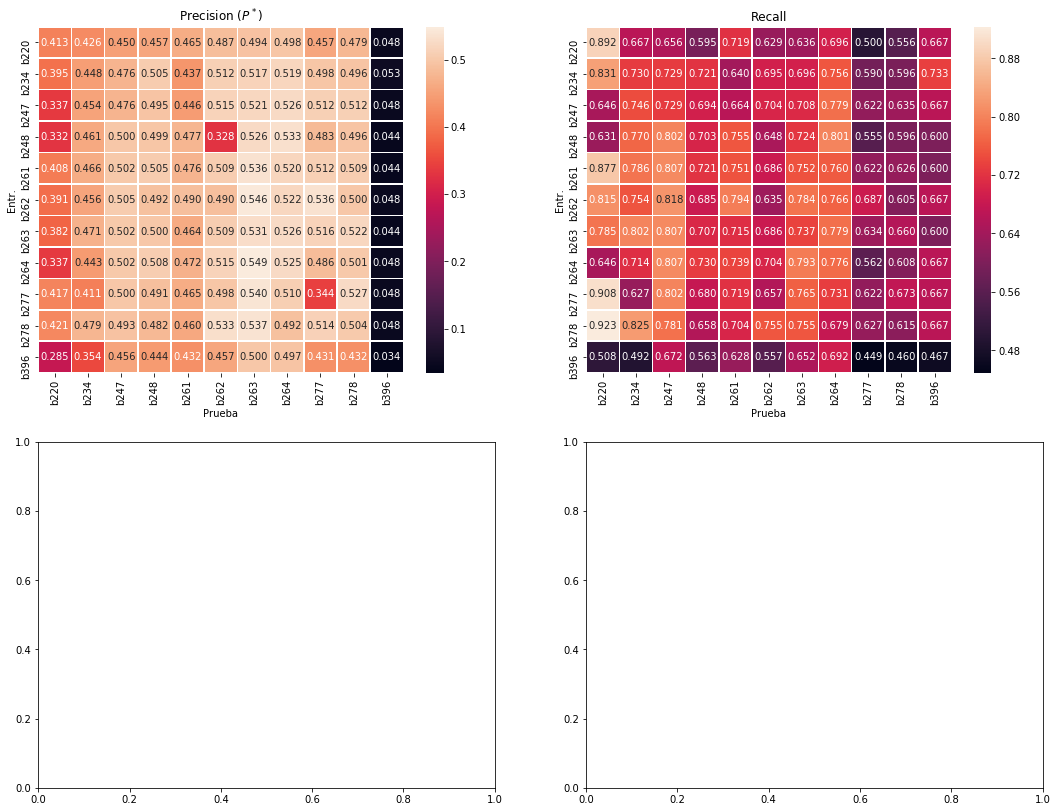

In [21]:
fig, aax = plt.subplots(2, 2, figsize=(18, 14))

def draw(aax, df, suffix):
    
    ax = aax[0]
    prec = df.swaplevel(0, 1, axis=1)[["prec"]]
    sns.heatmap(prec, annot=True, fmt='.3f',  linewidths=.5, ax=ax[0]);
    
    recall = df.swaplevel(0, 1, axis=1)[["rec"]]
    sns.heatmap(recall, annot=True, fmt='.3f', linewidths=.5, ax=ax[1]);

    labels = [l.get_text().split("-", 1)[-1] for l in ax[0].get_xticklabels()]
    ax[0].set_xticklabels(labels)
    ax[1].set_xticklabels(labels)

    ax[0].set_title(u"Precision ($P^*$)")
    ax[1].set_title(u"Recall")

    ax[0].set_xlabel("Prueba")
    ax[1].set_xlabel("Prueba")
    return prec, recall

prec, rec = draw(aax=aax, df=raw.loc["Peq"], suffix=u"Pequeña")

plt.savefig("workpoint2.pdf")
plt.show()

In [11]:
prec.columns = prec.columns.levels[1]
prec = prec.drop(["b396"], axis=1).drop(["b396"], axis=0)

rec.columns = rec.columns.levels[1]
rec = rec.drop(["b396"], axis=1).drop(["b396"], axis=0)

In [12]:
print "PREC", prec.values.mean()
print "RECALL", rec.values.mean()

PREC 0.481116542415
RECALL 0.710706178963
